### Natural Language Processing with TF-IDF, GloVe, Vader and Logistic Regression
Twitter Outrage Machine (OM); Insight Project- Michele Waters

* It has been observed in popular culture that a large "Twitter ratio" (a ratio of Twitter comments/likes >1) is usually indicative that other Twitter users strongly disagree with a Twitter post. 



* Hypothesis: the "Twitter ratio" can be used as a metric of Twitter outrage/ significant negative sentiment, 



* Let's use the tweet text data we collected ('1_Scrape_Tweets_Tweepy.py'), cleaned ('2_Clean_CSV_to_SQL.py' & '4_Clean_Text_Label_Categories_Merge_Tables_Data_Manipulation.ipynb'), and scoped down & explored ('5_EDA_Clustering.ipynb') in combination with the user account infomation we collected ('3_Get_Twitter_User_Data_Twython_no_key.py') from 100+ Twitter accounts across governement, news, entertainment/sports, and industry to see if we can predict whether a tweet will be ratioed.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3

In [9]:
conn=sqlite3.connect('../tweet_data/merged_tweets_2019_2020.db')
cursor= conn.cursor()

In [10]:
#Create function to query SQL data
def query_data(sql_statement):
    df=pd.read_sql(sql_statement, conn)
    #cursor.execute(sql_statement)
    return df.to_dict('records')

In [303]:
#Connect to database file with merged user account info/cleaned tweets and scoped data
df=pd.DataFrame(query_data('SELECT * FROM merged_twitter_data_gated'))

In [304]:
df.head()

,id,username,text,url_attached,hashtags,reply_to,date,formatted_date,to,link_to_tweet,...,text_processed,cleaned_text,encoded_urls,url_present,encoded_hashtag,hashtag_present,num_hashtags,d_log_ratio,ratio_target,cluster_labels
0,0,barackobama,As has always been true at key moments in hist...,https://www.obama.org/updates/president-obama-...,[],None,2020-06-07 23:25:01+00:00,Sun Jun 07 23:25:01 +0000 2020,None,https://twitter.com/BarackObama/status/1269772...,...,as has always been true at key moments in his...,true key moment history going depend young peo...,60582,1,0,0,0,-3,0,2
1,1,barackobama,We’ve seen the power that our voices have when...,https://twitter.com/ObamaFoundation/status/126...,[],ObamaFoundation,2020-06-06 00:37:08+00:00,Sat Jun 06 00:37:08 +0000 2020,ObamaFoundation,https://twitter.com/BarackObama/status/1269065...,...,we have seen the power that our voices have w...,seen power voice speak injustice know toll tak...,49129,1,0,0,0,-3,0,2
2,2,barackobama,"On National Gun Violence Awareness Day, we #We...",None,['#WearOrange'],None,2020-06-05 16:21:00+00:00,Fri Jun 05 16:21:00 +0000 2020,None,https://twitter.com/BarackObama/status/1268940...,...,on national gun violence awareness day we w...,national gun violence awareness day wearorange...,0,0,7251,1,1,-2,0,2
3,3,barackobama,"Third, every city in this country should be a ...",http://obama.org/mbka/about-mbk-communities,[],None,2020-06-04 23:15:58+00:00,Thu Jun 04 23:15:58 +0000 2020,None,https://twitter.com/BarackObama/status/1268682...,...,third every city in this country should be a...,city country mbk alliance community city count...,14350,1,0,0,0,-3,0,2
4,4,barackobama,"Second, every mayor should review their use of...",http://obama.org/mayor-pledge,[],None,2020-06-04 23:15:58+00:00,Thu Jun 04 23:15:58 +0000 2020,None,https://twitter.com/BarackObama/status/1268682...,...,second every mayor should review their use o...,second mayor review use force policy member co...,14349,1,0,0,0,-3,0,2


In [305]:
df.columns

Index(['id', 'username', 'text', 'url_attached', 'hashtags', 'reply_to',
       'date', 'formatted_date', 'to', 'link_to_tweet', 'tweet_id', 'retweets',
       'favorites', 'reply_count', 'author_id', 'ratio_comment_like',
       'ratio_comment_retweet', 'log_ratio', 'ratio_richter_likes',
       'ratio_richter_retweets', 'got_ratioed', 'got_richter_ratioed',
       'd_richter_like_ratio', 'd_richter_retweet_ratio', 'account_id',
       'location', 'name', 'description', 'url', 'created_at', 'verified',
       'followers_count', 'friends_count', 'listed_count', 'favourites_count',
       'statuses_count', 'category', 'doy', 'year', 'hour', 'minute', 'second',
       'text_processed', 'cleaned_text', 'encoded_urls', 'url_present',
       'encoded_hashtag', 'hashtag_present', 'num_hashtags', 'd_log_ratio',
       'ratio_target', 'cluster_labels'],
      dtype='object')

In [306]:
#Numeric columns
df.select_dtypes('number').columns

Index(['id', 'tweet_id', 'retweets', 'favorites', 'reply_count', 'author_id',
       'ratio_comment_like', 'ratio_comment_retweet', 'log_ratio',
       'ratio_richter_likes', 'ratio_richter_retweets', 'got_ratioed',
       'got_richter_ratioed', 'd_richter_like_ratio',
       'd_richter_retweet_ratio', 'account_id', 'verified', 'followers_count',
       'friends_count', 'listed_count', 'favourites_count', 'statuses_count',
       'doy', 'year', 'hour', 'minute', 'second', 'encoded_urls',
       'url_present', 'encoded_hashtag', 'hashtag_present', 'num_hashtags',
       'd_log_ratio', 'ratio_target', 'cluster_labels'],
      dtype='object')

In [307]:
df.select_dtypes('O').columns

Index(['username', 'text', 'url_attached', 'hashtags', 'reply_to', 'date',
       'formatted_date', 'to', 'link_to_tweet', 'location', 'name',
       'description', 'url', 'created_at', 'category', 'text_processed',
       'cleaned_text'],
      dtype='object')

In [308]:
df.category=df.category.astype('int64')

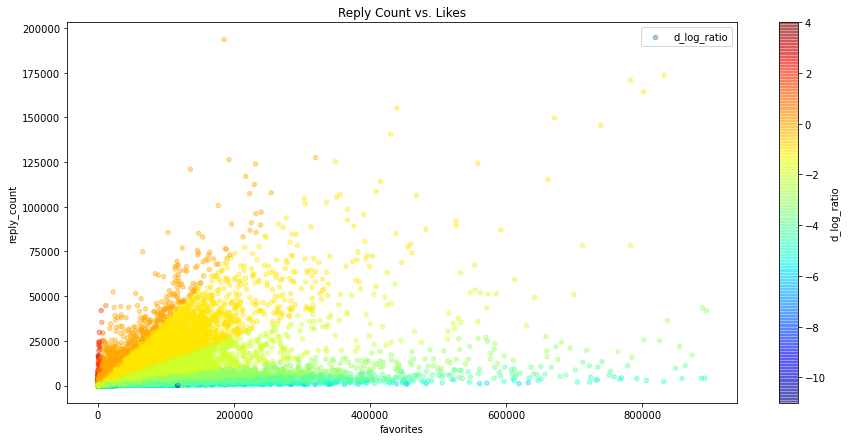

In [311]:
#Look at discrete values for log ratio score using matplotlib
fig, ax = plt.subplots()
df.plot(kind="scatter", x="favorites", y="reply_count", alpha=0.4,
            label='d_log_ratio',
            c='d_log_ratio', cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(15,7), title='Reply Count vs. Likes', ax=ax)
plt.legend()
plt.show()

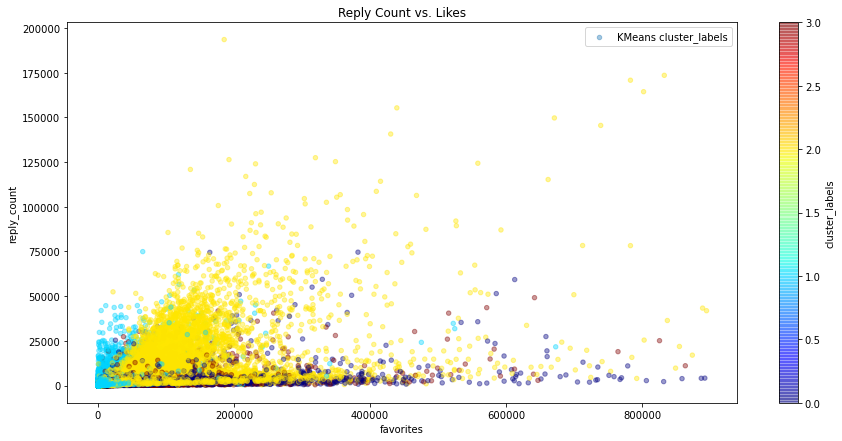

In [312]:
#Look at distribution of KMeans Clusters
fig, ax = plt.subplots()
df.plot(kind="scatter", x="favorites", y="reply_count", alpha=0.4,
            label='KMeans cluster_labels',
            c='cluster_labels', cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(15,7), title='Reply Count vs. Likes', ax=ax)
plt.legend()
plt.show()

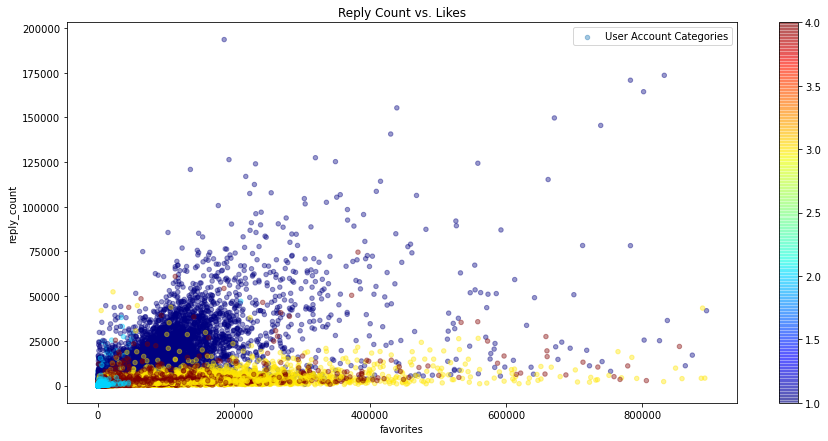

In [313]:
#Look at distribution of user account categories
cats=df.category.astype('int')
fig, ax = plt.subplots()
df.plot(kind="scatter", x="favorites", y="reply_count", alpha=0.4,
            label='User Account Categories',
            c=cats, cmap=plt.get_cmap("jet"), colorbar=True,
            figsize=(15,7), title='Reply Count vs. Likes', ax=ax)
plt.legend()
plt.show()

* Distribution of log ratio score, (i.e. log(Twitter replies/Twitter likes))

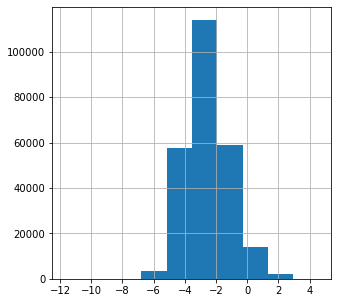

In [314]:
#Distribution of log ratio score
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
df.log_ratio.hist(ax=ax)
plt.show()

* Previously, we cleaned our data by removing tweets with 0 likes/retweets/replies


* We also further scoped our data by removing tweets with less than 50 replies and by removing outliers (removing tweets with more than $0.9*10^6$  likes and more than $0.3*10^6$ retweets)


* We made our log ratio score discrete, and created the target column 'ratio_target', which is equal to 1 where the discrete log ratio>0 and 0 elsewhere. We will use this as our metric for whether a tweet has been ratioed or not.

In [315]:
df.ratio_target.unique()

array([0, 1])

In [316]:
df.ratio_target.value_counts()

0    246867
1      2849
Name: ratio_target, dtype: int64

* Select column in df for text processing: 'text' (original text), 'text_processed' (lowercase, remove punctuation, remove contractions), or 'cleaned_text' ('text_processed', tokenized, lemmatized)

In [492]:
#Original tweet
df['text'][0]

'As has always been true at key moments in history, it’s going to depend on young people to go out there and rewrite what is possible. I couldn’t be prouder of all the young people leading that change right now. Here’s my advice for the Class of 2020:'

Despite there being no NaN values in the text data, I still discovered some missing text data that needed to be removed. Let's get the indices of these missing values, and drop rows with no text data:

In [493]:
list(df['text_processed'])[0]

' as has always been true at key moments in history  it is going to depend on young people to go out there and rewrite what is possible  i could not be prouder of all the young people leading that change right now  here is my advice for the class of      '

In [494]:
list(df['cleaned_text'])[0]

'true key moment history going depend young people rewrite possible prouder young people leading change right advice class'

In [495]:
text_col='cleaned_text'

In [496]:
#Select features for clustering; cluster labels was calculated in Jupyter Notebook 5 (EDA file)
selected_features=[text_col, 'followers_count','friends_count', 'listed_count', 'favourites_count', 'statuses_count',
                   'doy', 'year', 'hour', 'minute', 'second', 'encoded_urls',
                   'url_present', 'encoded_hashtag', 'hashtag_present', 'num_hashtags', 'category', 'ratio_target']

In [497]:
#Selected features
selected_df=df[selected_features]

In [498]:
selected_df.head()

,cleaned_text,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,encoded_urls,url_present,encoded_hashtag,hashtag_present,num_hashtags,category,ratio_target
0,true key moment history going depend young peo...,119658056,604838,220889,5,15843,159,2020,23,25,1,60582,1,0,0,0,1,0
1,seen power voice speak injustice know toll tak...,119658056,604838,220889,5,15843,158,2020,0,37,8,49129,1,0,0,0,1,0
2,national gun violence awareness day wearorange...,119658056,604838,220889,5,15843,157,2020,16,21,0,0,0,7251,1,1,1,0
3,city country mbk alliance community city count...,119658056,604838,220889,5,15843,156,2020,23,15,58,14350,1,0,0,0,1,0
4,second mayor review use force policy member co...,119658056,604838,220889,5,15843,156,2020,23,15,58,14349,1,0,0,0,1,0


In [499]:
#Cleaned tweet
selected_df[text_col][0]

'true key moment history going depend young people rewrite possible prouder young people leading change right advice class'

In [500]:
#double check there are no NaN values
selected_df[text_col].isna().sum()

0

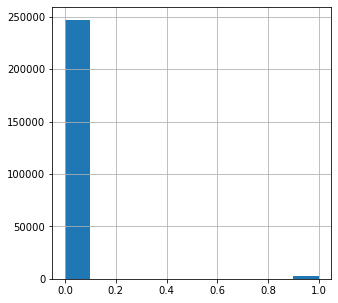

In [501]:
#Distribution of ratio (1) and non-ratio (0)
fig = plt.figure(figsize = (5,5))
ax = fig.gca()
selected_df.ratio_target.hist(ax=ax)
plt.show()

In [502]:
#Assign ratio_target to target variable
target=selected_df.ratio_target

In [503]:
target.value_counts()

0    246867
1      2849
Name: ratio_target, dtype: int64

* Twitter ratios now only make up 1.2% of our dataset. Therefore, we will use strategies to correct for this imbalance in our models, such as undersampling the majority (non-ratio) class.

In [507]:
#Twitter ratios in data
(target.value_counts()[1]/target.value_counts()[0])*100

1.1540627139309831

### Word Coud

* Let's see what the cleaned text looks like:

In [508]:
#!pip install wordcloud

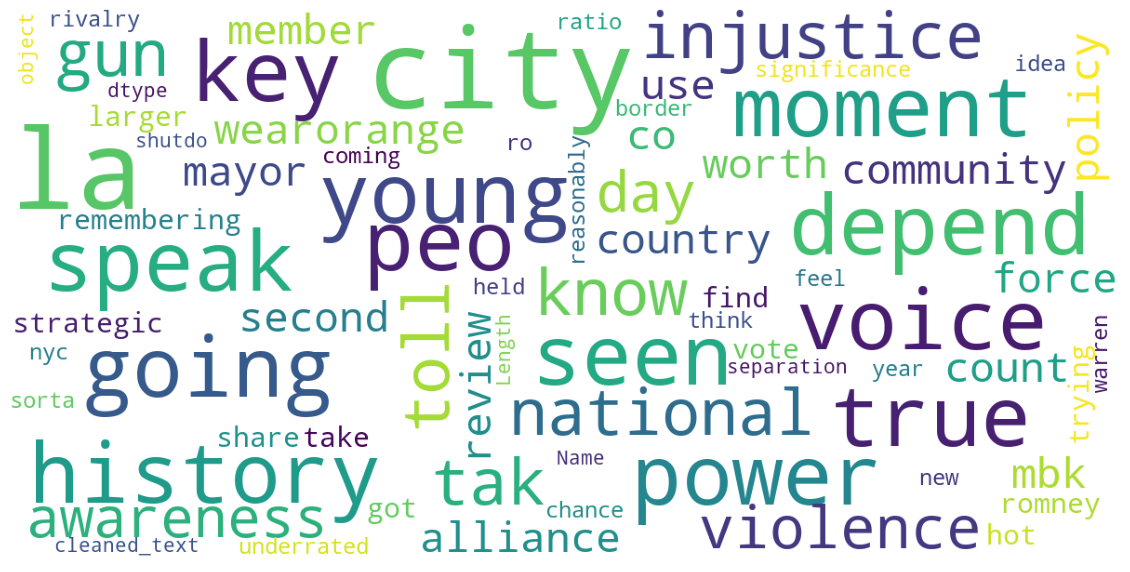

In [509]:
# wordcloud function

from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(selected_df[text_col])

* Let's also look at the word clouds for ratio vs. non-ratio

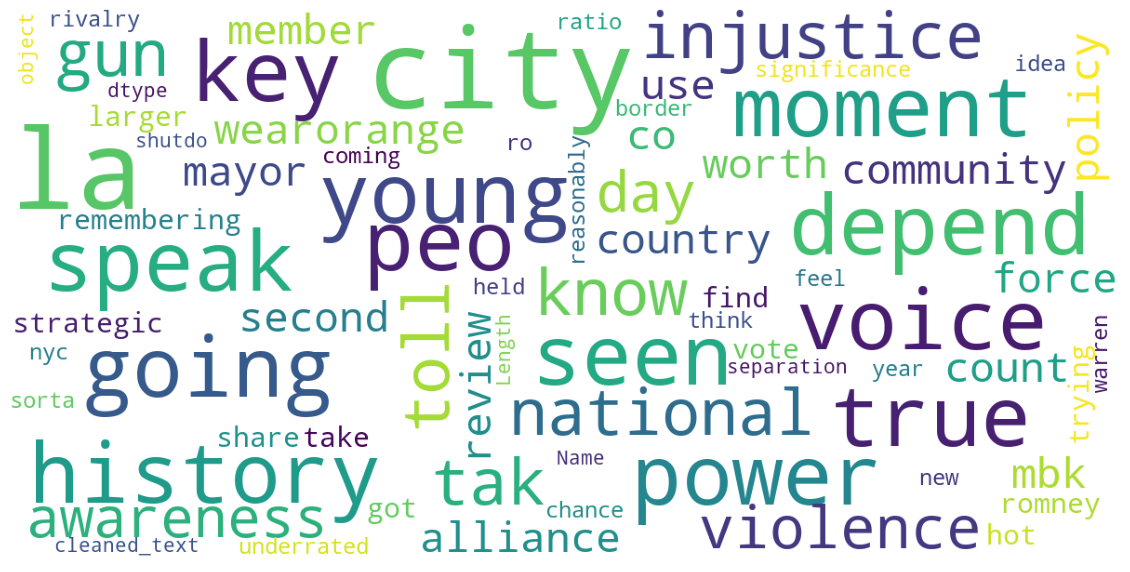

In [510]:
# Non-ratio word cloud
show_wordcloud(selected_df[selected_df.ratio_target==0][text_col])

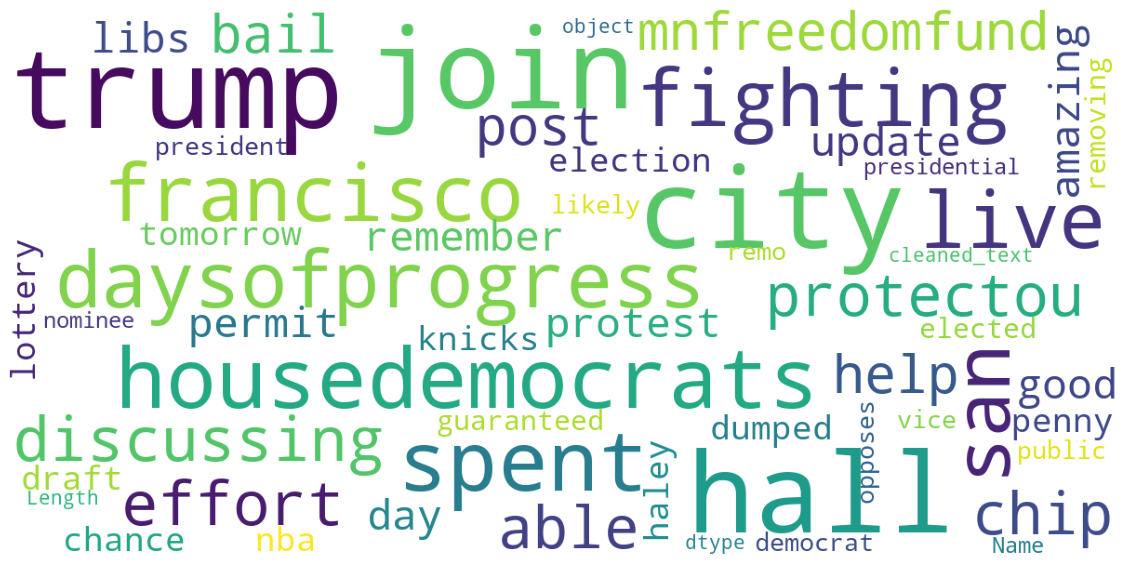

In [511]:
# Ratio word cloud
show_wordcloud(selected_df[selected_df.ratio_target==1][text_col])

* Many of the words in the 'ratio' word cloud appear to be political

### Sampling Strategy

* Since ratios represent only a small portion of our data, we can try randomly undersampling the majority (non-ratio class) or oversampling the minority (ratio class) so that we have a balanced dataset. 
* imblearn undersampling: #from imblearn.under_sampling import RandomUnderSampler ; sampling_strategy='majority'
* imblearn oversampling: #from imblearn.over_sampling import RandomOverSampler ; sampling_strategy='minority' 
* Let's try oversampling.

In [512]:
#!pip install imblearn

In [516]:
import imblearn
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import train_test_split

In [517]:
# define oversampling or undersampling strategy & drop target column from features
#sample = RandomUnderSampler(sampling_strategy='majority')
sample = RandomOverSampler(sampling_strategy='minority')

features, labels = sample.fit_resample(selected_df.drop(columns='ratio_target'), selected_df['ratio_target'])

X_train, X_validate, y_train, y_validate= train_test_split(features, labels, stratify=labels, random_state=42)

In [518]:
X_train.shape, X_validate.shape

((370300, 17), (123434, 17))

In [519]:
X_train.head()

,cleaned_text,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,encoded_urls,url_present,encoded_hashtag,hashtag_present,num_hashtags,category
21624,available new module diagnosis amp management ...,7941712,1721,31432,10731,52359,121,2020,8,19,35,5060,1,1656,1,1,1
212422,kawhi pt pascal pt combine lead raptor game vi...,30678899,1754,48688,540,256125,114,2019,1,55,31,0,0,7299,1,2,4
409504,nuclear,1367420,115,8915,969,128887,20,2019,14,42,24,34761,1,0,0,0,2
20219,congratulation doechancellor team nycschools t...,1499918,1378,4808,441,19295,30,2019,22,52,55,48882,1,0,0,0,1
126986,sad tonight heck season thanks buck,283864,290,3510,399,17964,146,2019,3,15,7,0,0,0,0,0,1


Be mindful, the original sample indices have been rearanged. But now we have an even number of ratios in our training and validation sets, and ratios make up ~50% of each data set:

In [520]:
features[text_col].loc[0]

'true key moment history going depend young people rewrite possible prouder young people leading change right advice class'

In [521]:
selected_df[text_col].loc[0]

'true key moment history going depend young people rewrite possible prouder young people leading change right advice class'

In [522]:
df.text.loc[0]

'As has always been true at key moments in history, it’s going to depend on young people to go out there and rewrite what is possible. I couldn’t be prouder of all the young people leading that change right now. Here’s my advice for the Class of 2020:'

In [523]:
#Ratios make up 50% of dataset
y_train.mean(), y_validate.mean()

(0.5, 0.5)

In [524]:
#Total number of ratios in training/validation sets
y_train.sum(), y_validate.sum()

(185150, 61717)

### TF-IDF

* Since ratios represent only a small portion of our data, let's start by using TF-IDF to try to surface rare words that may be highly correlated to ratios


* Term frequency–inverse document frequency-- a numerical statistic intended to reflect how important a word is to a document in a collection/corpus.

In [525]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

vect = TfidfVectorizer()
tfidf_matrix_train = vect.fit_transform(X_train[text_col])
tfidf_df_train = pd.DataFrame(tfidf_matrix_train.toarray(), columns = vect.get_feature_names(), index=X_train.index)
tfidf_matrix_val = vect.transform(X_validate[text_col])
tfidf_df_val = pd.DataFrame(tfidf_matrix_val.toarray(), columns = vect.get_feature_names(), index=X_validate.index)
tfidf_df_train.head()

KeyboardInterrupt: 

Logistic Regression is appropriate for our binary target (ratio v. non-ratio). To start, let's only use text data for our features 

In [359]:
from sklearn.linear_model import LogisticRegression

In [360]:
clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
clf.fit(tfidf_df_train, y_train)
print(clf.score(tfidf_df_val, y_validate))

0.8189473684210526


Let's also look at Precision and Recall

In [361]:
from sklearn import metrics

In [362]:
# Predicting with a test dataset
best_predict=clf.predict(tfidf_df_val)
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(best_predict)))
print("Logistic Regression Precision:",metrics.precision_score(y_validate, pd.Series(best_predict)))
print("Logistic Regression Recall:",metrics.recall_score(y_validate, pd.Series(best_predict)))

Logistic Regression Accuracy: 0.8189473684210526
Logistic Regression Precision: 0.8886986301369864
Logistic Regression Recall: 0.7289325842696629


Let's look at the top 50 features of our TF-IDF model

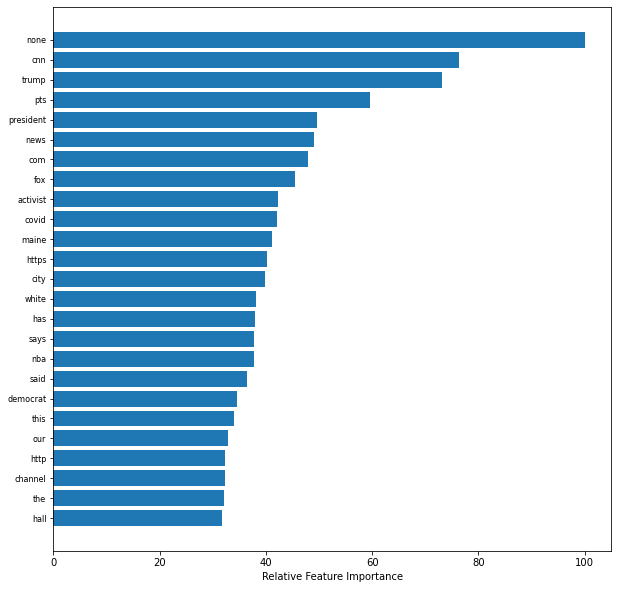

In [363]:
#Top 50 features from TF-IDF
feature_importance = abs(clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max()) #convert importance to percentage
sorted_idx = np.argsort(feature_importance)[::-1][:25][::-1]
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(pd.DataFrame(tfidf_df_val).columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.show()

Let's see if we can improve our score by adding in the user account information, but let's scale the account data

In [364]:
from sklearn.preprocessing import StandardScaler

In [366]:
num_features=features.drop(columns=text_col)

In [367]:
num_features.columns

Index(['followers_count', 'friends_count', 'listed_count', 'favourites_count',
       'statuses_count', 'doy', 'year', 'hour', 'minute', 'second',
       'encoded_urls', 'url_present', 'encoded_hashtag', 'hashtag_present',
       'num_hashtags', 'category'],
      dtype='object')

In [368]:
#Continuous features for scaling
scale_features=['followers_count', 'friends_count', 'listed_count', 'favourites_count',
       'statuses_count', 'doy', 'year', 'hour', 'minute', 'second',
       'encoded_urls', 'encoded_hashtag', 'num_hashtags']

In [369]:
non_scale_features= [col for col in num_features.columns if col not in scale_features]
non_scale_features

['url_present', 'hashtag_present', 'category']

In [370]:
scale=StandardScaler()
scaled_features=pd.DataFrame(scale.fit_transform(num_features[scale_features]), columns=scale_features, index=num_features.index)
scaled_features=pd.concat([scaled_features, num_features[non_scale_features]], axis=1)
scaled_features.head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,encoded_urls,encoded_hashtag,num_hashtags,url_present,hashtag_present,category
0,-0.046309,0.003081,-0.042987,-0.288563,0.423672,-0.651763,1.666888,0.910256,-0.382655,1.382420,1.097961,-0.376147,-0.391965,1,0,2
1,-0.329824,-0.082620,-0.191700,-0.229549,-1.266253,1.600469,-0.599920,-1.733494,-0.724673,0.933094,-1.125516,1.943503,2.866122,0,1,3
2,1.304457,-0.017866,1.211477,-0.279709,2.079413,1.797669,-0.599920,-1.469119,0.757406,-0.639549,-1.125516,4.309708,2.866122,0,1,4
3,-0.285856,-0.140508,-0.236817,-0.233048,-0.855694,-0.215847,1.666888,-1.469119,0.529394,-0.021725,1.739773,-0.376147,-0.391965,1,0,2
4,0.992480,0.062880,1.164911,-0.259413,1.419787,1.413648,-0.599920,0.117131,-1.636722,-0.471052,-1.125516,0.344851,1.237078,0,1,4


In [371]:
scaled_features.loc[X_train.index].head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,encoded_urls,encoded_hashtag,num_hashtags,url_present,hashtag_present,category
5471,-0.473880,-0.120951,-0.602382,-0.281997,-1.321145,-1.170710,1.666888,0.513694,1.384440,-1.257373,-1.125516,-0.376147,-0.391965,0,0,1
1714,-0.026340,-0.020735,0.516972,-0.110725,-0.728095,-0.433805,1.666888,0.381506,0.187376,-0.134057,-1.125516,0.504653,1.237078,0,1,1
871,4.311772,-0.166322,3.889120,-0.288597,-0.721977,0.510680,-0.599920,-0.015056,-1.351707,-0.639549,-1.125516,-0.376147,-0.391965,0,0,1
2559,1.304457,-0.017866,1.211477,-0.279709,2.079413,-0.579110,1.666888,-1.469119,0.301382,0.933094,-1.125516,-0.376147,-0.391965,0,0,4
2983,-0.452457,0.147277,-0.369512,-0.284998,0.518658,0.666364,-0.599920,0.249319,1.498446,1.494752,-0.765140,-0.376147,-0.391965,1,0,2


In [372]:
merged_train_df=pd.concat([scaled_features.loc[X_train.index], tfidf_df_train], axis=1)
merged_train_df.head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,...,zsayl,zucker,zuij,zutzk,zxz,zy,zymj,zyp,zz,zzz
5471,-0.473880,-0.120951,-0.602382,-0.281997,-1.321145,-1.170710,1.666888,0.513694,1.384440,-1.257373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1714,-0.026340,-0.020735,0.516972,-0.110725,-0.728095,-0.433805,1.666888,0.381506,0.187376,-0.134057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
871,4.311772,-0.166322,3.889120,-0.288597,-0.721977,0.510680,-0.599920,-0.015056,-1.351707,-0.639549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2559,1.304457,-0.017866,1.211477,-0.279709,2.079413,-0.579110,1.666888,-1.469119,0.301382,0.933094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2983,-0.452457,0.147277,-0.369512,-0.284998,0.518658,0.666364,-0.599920,0.249319,1.498446,1.494752,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [373]:
merged_val_df=pd.concat([scaled_features.loc[X_validate.index], tfidf_df_val], axis=1)
merged_val_df.head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,...,zsayl,zucker,zuij,zutzk,zxz,zy,zymj,zyp,zz,zzz
3191,-0.449251,0.427761,-0.196691,4.094791,1.273932,0.282343,-0.599920,0.249319,1.498446,1.326255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5303,-0.046309,0.003081,-0.042987,-0.288563,0.423672,-0.392289,1.666888,0.778069,-1.579719,-1.201207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
815,-0.046309,0.003081,-0.042987,-0.288563,0.423672,-0.900857,1.666888,1.174632,-0.040636,-0.358720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2437,-0.449163,-0.122602,-0.467393,-0.111190,-0.383132,2.181690,-0.599920,0.910256,0.643400,-1.145041,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2556,4.311772,-0.166322,3.889120,-0.288597,-0.721977,-1.347152,-0.599920,0.249319,-0.097639,1.157757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Logistic Regression with account features and TF-IDF

In [374]:
clf2 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
clf2.fit(merged_train_df, y_train)
print(clf2.score(merged_val_df, y_validate))

0.872280701754386


In [375]:
#Predicting with a validation dataset
best_predict2=clf2.predict(merged_val_df)
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(best_predict2)))
print("Logistic Regression Precision:",metrics.precision_score(y_validate, pd.Series(best_predict2)))
print("Logistic Regression Recall:",metrics.recall_score(y_validate, pd.Series(best_predict2)))
print("Logistic Regression F1 Score:",metrics.f1_score(y_validate, pd.Series(best_predict2)))

Logistic Regression Accuracy: 0.872280701754386
Logistic Regression Precision: 0.8271604938271605
Logistic Regression Recall: 0.9410112359550562
Logistic Regression F1 Score: 0.8804204993429698


In [376]:
tfidf_df_train.head()

,aa,aaddmhe,aapivictoryfund,aaron,aaronrodgers,aarpmaine,aatf,ab,abandon,abandoned,...,zsayl,zucker,zuij,zutzk,zxz,zy,zymj,zyp,zz,zzz
5471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Alternatively, instead of combining the TF-IDF Matrix with the user account info matrix, let's see if we can stack the TFIDF model and use the account info to predict the residuals.

In [377]:
clf.predict_proba(tfidf_df_train)

array([[0.47150734, 0.52849266],
       [0.54857296, 0.45142704],
       [0.73610517, 0.26389483],
       ...,
       [0.04929776, 0.95070224],
       [0.37432168, 0.62567832],
       [0.78375189, 0.21624811]])

In [378]:
def residuals(clf=clf, X=tfidf_df_train, y=y_train):
    resid=[]
    probability_1= [val[1] for val in clf.predict_proba(X)]
    j=0 
    for i in y.index:
        if y[i]==1:
            resid.append(1-probability_1[j])
        else:
            resid.append(-1*probability_1[j])
        j+=1
    return resid

In [379]:
resid_train=residuals()
resid_train[:3]

[0.4715073411464086, -0.45142703727737266, -0.2638948300341331]

In [380]:
resid_val=residuals(X=tfidf_df_val, y=y_validate)
resid_val[:3]

[0.617269391271478, 0.6717538798012568, -0.2637721120175496]

In [381]:
account_train=scaled_features.loc[X_train.index]
account_val=scaled_features.loc[X_validate.index]

In [382]:
account_train.head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,encoded_urls,encoded_hashtag,num_hashtags,url_present,hashtag_present,category
5471,-0.473880,-0.120951,-0.602382,-0.281997,-1.321145,-1.170710,1.666888,0.513694,1.384440,-1.257373,-1.125516,-0.376147,-0.391965,0,0,1
1714,-0.026340,-0.020735,0.516972,-0.110725,-0.728095,-0.433805,1.666888,0.381506,0.187376,-0.134057,-1.125516,0.504653,1.237078,0,1,1
871,4.311772,-0.166322,3.889120,-0.288597,-0.721977,0.510680,-0.599920,-0.015056,-1.351707,-0.639549,-1.125516,-0.376147,-0.391965,0,0,1
2559,1.304457,-0.017866,1.211477,-0.279709,2.079413,-0.579110,1.666888,-1.469119,0.301382,0.933094,-1.125516,-0.376147,-0.391965,0,0,4
2983,-0.452457,0.147277,-0.369512,-0.284998,0.518658,0.666364,-0.599920,0.249319,1.498446,1.494752,-0.765140,-0.376147,-0.391965,1,0,2


In [383]:
len(account_val.columns)

16

In [384]:
from sklearn.ensemble import RandomForestRegressor

In [385]:
account_rf=RandomForestRegressor(random_state=42).fit(account_train, resid_train)

In [386]:
account_rf.score(account_val, resid_val)

0.3166243907848969

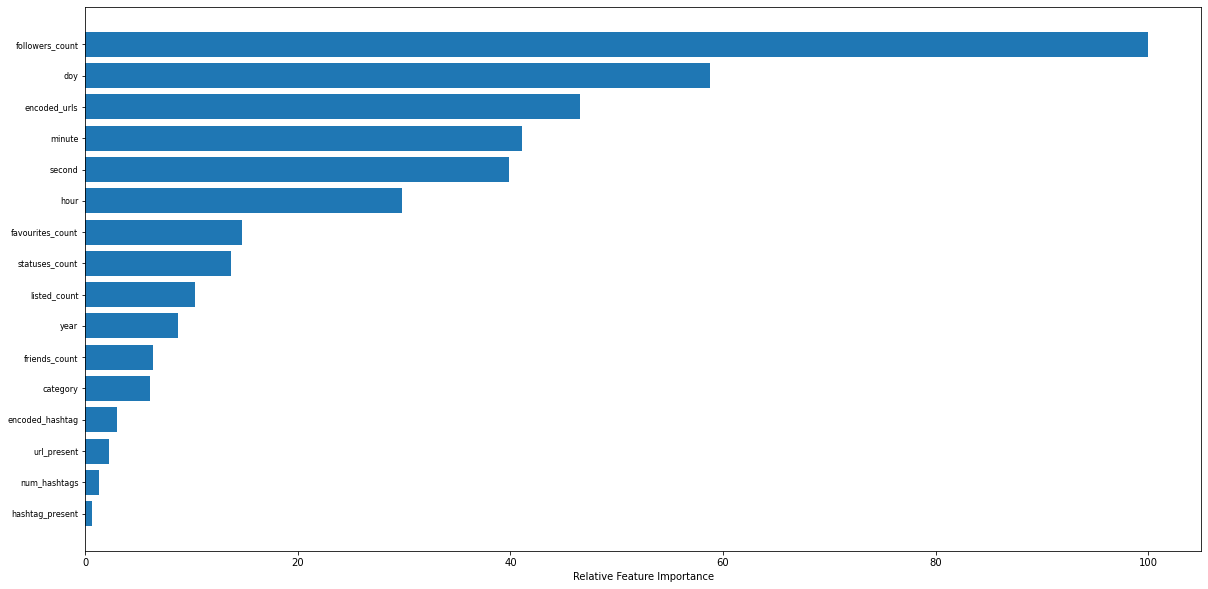

In [387]:
#Top features from Account Features
feature_importance = abs(account_rf.feature_importances_)
feature_importance = 100.0 * (feature_importance / feature_importance.max()) #convert importance to percentage
sorted_idx = np.argsort(feature_importance)[::-1][::-1]
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(20,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(pd.DataFrame(account_val).columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.show()

In [388]:
top_features=pd.DataFrame(account_val).columns[sorted_idx][::-1]
top_features

Index(['followers_count', 'doy', 'encoded_urls', 'minute', 'second', 'hour',
       'favourites_count', 'statuses_count', 'listed_count', 'year',
       'friends_count', 'category', 'encoded_hashtag', 'url_present',
       'num_hashtags', 'hashtag_present'],
      dtype='object')

In [389]:
account_rf=RandomForestRegressor(random_state=42).fit(account_train[['followers_count']], resid_train)

In [390]:
account_rf2s=[RandomForestRegressor(random_state=42).fit(account_train[top_features[:i]], resid_train) for i in range(1, len(top_features)+1)]

In [391]:
account_rf2s_scores=[account_rf2s[i].score(account_val[top_features[:i+1]], resid_val) for i in range(len(top_features))]

In [392]:
account_rf2s_scores

[0.3165768519962965,
 0.2567044922386512,
 0.2704820633718521,
 0.28198566325299634,
 0.291655296446344,
 0.29458702170604856,
 0.31657756661652037,
 0.31024560794293776,
 0.30597557446169077,
 0.31268364349679434,
 0.3167490468833346,
 0.3185502936816117,
 0.32061010545493374,
 0.3202337507335581,
 0.3187422352196204,
 0.31897400799873765]

Since our model does best with only the first feature, let's only use the follower's count to predict residuals.

In [393]:
account_rf2=RandomForestRegressor(random_state=42).fit(account_train[['followers_count']], resid_train)

In [394]:
account_rf2.score(account_val[['followers_count']], resid_val)

0.3165768519962965

In [395]:
def add_resid_predictions(account_rf=account_rf2,account_val=account_val[['followers_count']], clf=clf, vector_X=tfidf_df_val, threshold=0.5):
    resid_prob_val=account_rf.predict(account_val)
    new_prob=[val[1] for val in clf.predict_proba(vector_X)]+resid_prob_val
    new_prob=pd.Series(new_prob).apply(lambda x: x if x>=0 else 0)
    percent_prob= [round(num*100, 2) for num in new_prob]
    pred_new_prob=[]
    for num in new_prob:
        if num>=threshold: #threshold; default, predict 1 if threshold is over 0.5, 0 if less than 0.5
            pred_new_prob.append(1)
        else:
            pred_new_prob.append(0)
    return [percent_prob, pred_new_prob]
results=add_resid_predictions()
percent_prob=results[0] #percent probability of being ratioed
pred_new_prob=results[1] #predictions (ratio/non-ratio)

In [396]:
percent_prob[:10]

[62.08, 14.01, 7.57, 0.43, 20.82, 66.51, 104.45, 0.0, 0.96, 23.56]

In [397]:
#Probabilities of being ratioed
pred_new_prob[:4]

[1, 0, 0, 0]

In [398]:
y_validate[:4]

3191    1
5303    1
815     0
2437    0
Name: ratio_target, dtype: int64

In [399]:
#Predicting with a validation dataset
print("Combined Log Reg+ RF Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(pred_new_prob)))
print("Combined Log Reg+ RF Precision:",metrics.precision_score(y_validate, pd.Series(pred_new_prob)))
print("Combined Log Reg+ RF Recall:",metrics.recall_score(y_validate, pd.Series(pred_new_prob)))
print("Combined Log Reg+ RF F1 Score:",metrics.f1_score(y_validate, pd.Series(pred_new_prob)))

Combined Log Reg+ RF Regression Accuracy: 0.8842105263157894
Combined Log Reg+ RF Precision: 0.8793342579750347
Combined Log Reg+ RF Recall: 0.8904494382022472
Combined Log Reg+ RF F1 Score: 0.8848569434752268


We were able to improve our model, with a recall ~0.9

### GloVe Word Embedding

* https://nlp.stanford.edu/projects/glove/

In [99]:
#!pip install gensim

In [100]:
#Import GloVe using gensim
import gensim.downloader as api
glove_twitter = api.load("glove-twitter-200")

In [ ]:
#If you desire to locally import, instead of using gensim import: 
# def loadGloveModel(File):
#     print("Loading Glove Model")
#     f = open(File,'r')
#     gloveModel = {}
#     for line in f:
#         splitLines = line.split()
#         word = splitLines[0]
#         wordEmbedding = np.array([float(value) for value in splitLines[1:]])
#         gloveModel[word] = wordEmbedding
#     print(len(gloveModel)," words loaded!")
#     return gloveModel

#glove_twitter=loadGloveModel('glove.twitter.27B.200d.txt')

We can use pre-trained GloVe vectors to find similar words:

In [400]:
glove_twitter['hello'][:5]

array([ 0.34683, -0.19612, -0.34923, -0.28158, -0.75627], dtype=float32)

In [401]:
glove_twitter.most_similar('hello')

[('hey', 0.7900470495223999),
 ('hi', 0.7673512697219849),
 ('dear', 0.7181551456451416),
 ('welcome', 0.6986153721809387),
 ('morning', 0.6838774681091309),
 ('goodbye', 0.6520751118659973),
 ('thanks', 0.6399416327476501),
 ('thank', 0.6307862401008606),
 ('yes', 0.6267277598381042),
 ('guys', 0.6202508211135864)]

Let's create a function to assemble our embedded tweet vectors. This takes the average or sum of individual word vectors for each tweet:

In [402]:
def word_to_glove_vector(tweet, size, vectors, aggregation='mean'):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tweet.split():
        try:
            vec += vectors[word].reshape((1, size))
            count += 1.
        except KeyError:
            continue
    if aggregation == 'mean':
        if count != 0:
            vec /= count
        return vec
    elif aggregation == 'sum':
        return vec

In [404]:
from sklearn.preprocessing import scale

In [526]:
#Assemble GloVe vectors, using mean aggregation
train_vecs_glove_mean = scale(np.concatenate([word_to_glove_vector(tweet, 200, glove_twitter,'mean') for tweet in X_train[text_col].values]))
validation_vecs_glove_mean = scale(np.concatenate([word_to_glove_vector(tweet, 200, glove_twitter,'mean') for tweet in X_validate[text_col].values]))

KeyboardInterrupt: 

In [ ]:
g_clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
g_clf.fit(train_vecs_glove_mean, y_train)
print(g_clf.score(validation_vecs_glove_mean, y_validate))

In [407]:
from sklearn import metrics
# Predicting with a test dataset
best_predict3=g_clf.predict(validation_vecs_glove_mean)
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(best_predict3)))
print("Logistic Regression Precision:",metrics.precision_score(y_validate, pd.Series(best_predict3)))
print("Logistic Regression Recall:",metrics.recall_score(y_validate, pd.Series(best_predict3)))
print("Logistic Regression F1 Score:",metrics.f1_score(y_validate, pd.Series(best_predict3)))

Logistic Regression Accuracy: 0.7880701754385965
Logistic Regression Precision: 0.8144171779141104
Logistic Regression Recall: 0.7457865168539326
Logistic Regression F1 Score: 0.7785923753665689


Let's look at feature importance of our tweet vectors:

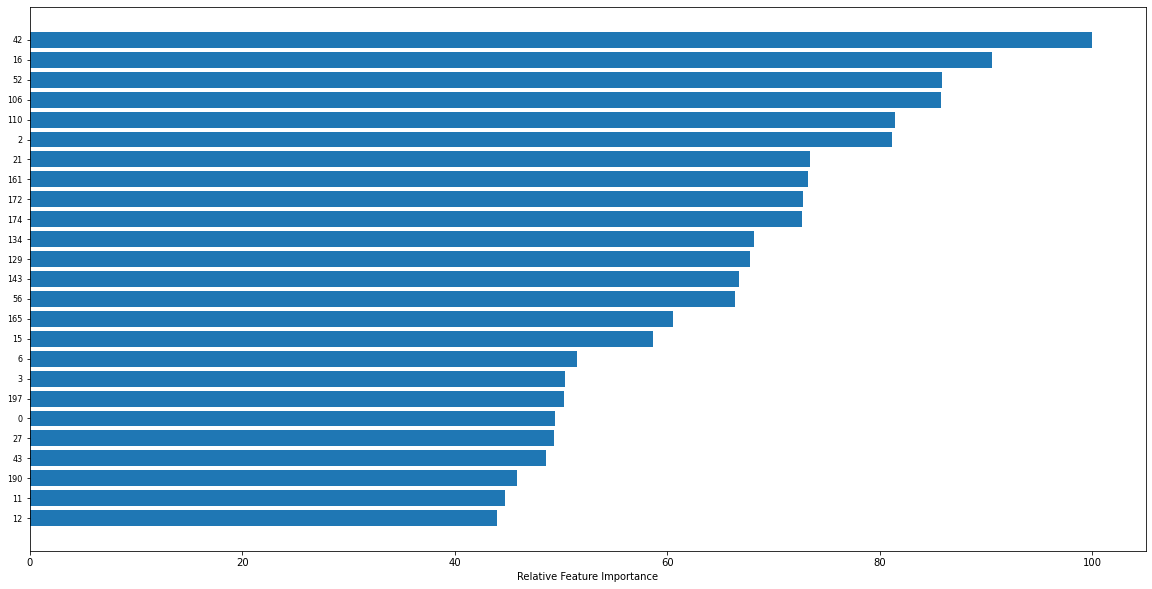

In [408]:
feature_importance = abs(g_clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1][:25][::-1] #get top features
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(20,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(pd.DataFrame(validation_vecs_glove_mean).columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')
plt.show()

Let's look at top 50 word vectors:

In [409]:
top_word_vectors=np.array(pd.DataFrame(validation_vecs_glove_mean).columns)[sorted_idx][::-1]

In [410]:
top_word_vectors

array([ 42,  16,  52, 106, 110,   2,  21, 161, 172, 174, 134, 129, 143,
        56, 165,  15,   6,   3, 197,   0,  27,  43, 190,  11,  12])

In [411]:
y_validate.index

Int64Index([3191, 5303,  815, 2437, 2556, 5483, 3990, 2353,  658, 2017,
            ...
            4315, 2916, 1440, 3254, 2454,  317, 4062, 1294, 5689, 1095],
           dtype='int64', length=1425)

In [412]:
#pd.DataFrame(validation_vecs_glove_mean, index=y_validate.index)[top_word_vectors]

In [414]:
#concatenate cleaned text, word vectors, and ratio target
top_vec_df= pd.concat([X_validate[text_col], pd.DataFrame(validation_vecs_glove_mean, index=y_validate.index)[top_word_vectors], pd.DataFrame(y_validate, columns=['ratio_target'])], axis=1)

In [418]:
top_vec_df.iloc[0:].sort_values(by=list(top_word_vectors), ascending=False).head()

,text_processed,42,16,52,106,110,2,21,161,172,...,6,3,197,0,27,43,190,11,12,ratio_target
2454,agreed,3.206518,-0.045182,-1.455369,-0.969718,-0.259144,0.287356,-0.256925,0.216322,3.259169,...,2.129154,-0.040160,3.795085,0.742605,0.995123,0.559529,-2.143796,1.782619,0.578809,0
395,morehouse,2.641850,0.675747,-2.292424,1.177996,1.875070,1.836824,-0.132822,-3.452817,-0.409755,...,-3.513490,0.747711,0.399035,6.097277,0.777200,-1.897943,1.424681,0.499545,3.616957,0
64,moreyears,2.578372,-0.055932,0.579188,0.059691,0.681410,0.304354,2.573910,-3.438354,0.995998,...,-6.049573,-1.454899,-2.654923,1.822328,-3.110458,1.432253,3.034390,3.051344,4.894623,0
373,sister love lol kuwtk,2.354550,0.857629,-0.659364,-0.195986,0.389371,0.224637,-0.700204,-1.308210,-0.300890,...,-0.062817,-0.430814,-1.410055,-0.318720,0.577970,-1.176037,-2.799014,1.835083,3.160272,0
2776,no femi,2.216635,0.979339,-0.995812,0.413573,1.693316,1.927578,0.954997,-1.735498,0.582861,...,-1.980141,0.197692,1.017986,-1.912641,-0.450457,-0.008493,-1.737607,0.343278,1.900135,0


In [419]:
import seaborn as sns

In [420]:
corr_df=top_vec_df.corr()
corr_df.head()

,42,16,52,106,110,2,21,161,172,174,...,6,3,197,0,27,43,190,11,12,ratio_target
42,1.000000,0.937657,-0.927324,-0.896507,0.901115,0.897957,-0.868408,-0.820856,0.819297,0.807527,...,-0.525163,-0.836265,-0.652160,0.526525,0.889414,0.809413,-0.276801,0.879115,0.628151,-0.555598
16,0.937657,1.000000,-0.949786,-0.927538,0.928591,0.921069,-0.865155,-0.802434,0.831742,0.847240,...,-0.541439,-0.861106,-0.672442,0.498621,0.916546,0.831449,-0.269406,0.922224,0.622231,-0.570739
52,-0.927324,-0.949786,1.000000,0.907557,-0.906186,-0.886102,0.864811,0.801291,-0.803458,-0.824192,...,0.518458,0.850067,0.670522,-0.457670,-0.892491,-0.818064,0.248834,-0.905053,-0.635236,0.549869
106,-0.896507,-0.927538,0.907557,1.000000,-0.897811,-0.874990,0.865253,0.765053,-0.822157,-0.855107,...,0.588239,0.857986,0.670087,-0.471960,-0.876486,-0.793025,0.179332,-0.882814,-0.600817,0.499836
110,0.901115,0.928591,-0.906186,-0.897811,1.000000,0.896318,-0.842560,-0.745886,0.766041,0.835697,...,-0.599831,-0.867019,-0.685211,0.518847,0.879267,0.805141,-0.193918,0.875507,0.594273,-0.528966


In [421]:
corr_df.sort_values(by='ratio_target', ascending=False).head()

,42,16,52,106,110,2,21,161,172,174,...,6,3,197,0,27,43,190,11,12,ratio_target
ratio_target,-0.555598,-0.570739,0.549869,0.499836,-0.528966,-0.582739,0.499815,0.541714,-0.448863,-0.463413,...,0.299187,0.538912,0.445908,-0.317344,-0.559696,-0.529840,0.331249,-0.548185,-0.401356,1.000000
15,-0.889515,-0.902741,0.887934,0.870891,-0.897585,-0.871715,0.832226,0.789130,-0.778980,-0.793238,...,0.584094,0.870367,0.643364,-0.482981,-0.873644,-0.758263,0.209273,-0.881371,-0.569810,0.552101
52,-0.927324,-0.949786,1.000000,0.907557,-0.906186,-0.886102,0.864811,0.801291,-0.803458,-0.824192,...,0.518458,0.850067,0.670522,-0.457670,-0.892491,-0.818064,0.248834,-0.905053,-0.635236,0.549869
161,-0.820856,-0.802434,0.801291,0.765053,-0.745886,-0.794035,0.741681,1.000000,-0.693672,-0.726376,...,0.500276,0.769150,0.603578,-0.462856,-0.780833,-0.715148,0.385803,-0.785894,-0.640201,0.541714
165,-0.929293,-0.947318,0.922886,0.905417,-0.911517,-0.881726,0.872007,0.769290,-0.806283,-0.839917,...,0.459951,0.808711,0.687463,-0.470644,-0.887287,-0.788272,0.203664,-0.869262,-0.566943,0.538929


In [422]:
corr_df[(corr_df.sort_values(by='ratio_target', ascending=False)['ratio_target']>0)]

/Users/michelewaters/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,42,16,52,106,110,2,21,161,172,174,...,6,3,197,0,27,43,190,11,12,ratio_target
52,-0.927324,-0.949786,1.000000,0.907557,-0.906186,-0.886102,0.864811,0.801291,-0.803458,-0.824192,...,0.518458,0.850067,0.670522,-0.457670,-0.892491,-0.818064,0.248834,-0.905053,-0.635236,0.549869
106,-0.896507,-0.927538,0.907557,1.000000,-0.897811,-0.874990,0.865253,0.765053,-0.822157,-0.855107,...,0.588239,0.857986,0.670087,-0.471960,-0.876486,-0.793025,0.179332,-0.882814,-0.600817,0.499836
21,-0.868408,-0.865155,0.864811,0.865253,-0.842560,-0.841346,1.000000,0.741681,-0.728847,-0.768016,...,0.508611,0.789372,0.698018,-0.454025,-0.856666,-0.725814,0.250666,-0.831857,-0.561977,0.499815
161,-0.820856,-0.802434,0.801291,0.765053,-0.745886,-0.794035,0.741681,1.000000,-0.693672,-0.726376,...,0.500276,0.769150,0.603578,-0.462856,-0.780833,-0.715148,0.385803,-0.785894,-0.640201,0.541714
134,-0.871700,-0.895421,0.879534,0.848307,-0.852263,-0.844099,0.817402,0.729015,-0.792939,-0.788584,...,0.380269,0.746114,0.601034,-0.437393,-0.869483,-0.743994,0.217590,-0.820056,-0.485927,0.524025
165,-0.929293,-0.947318,0.922886,0.905417,-0.911517,-0.881726,0.872007,0.769290,-0.806283,-0.839917,...,0.459951,0.808711,0.687463,-0.470644,-0.887287,-0.788272,0.203664,-0.869262,-0.566943,0.538929
15,-0.889515,-0.902741,0.887934,0.870891,-0.897585,-0.871715,0.832226,0.789130,-0.778980,-0.793238,...,0.584094,0.870367,0.643364,-0.482981,-0.873644,-0.758263,0.209273,-0.881371,-0.569810,0.552101
6,-0.525163,-0.541439,0.518458,0.588239,-0.599831,-0.551011,0.508611,0.500276,-0.426880,-0.522115,...,1.000000,0.654091,0.483140,-0.324530,-0.460966,-0.536729,0.022854,-0.571788,-0.609137,0.299187
3,-0.836265,-0.861106,0.850067,0.857986,-0.867019,-0.864870,0.789372,0.769150,-0.718079,-0.772782,...,0.654091,1.000000,0.686990,-0.510749,-0.835687,-0.800720,0.280323,-0.863238,-0.623541,0.538912
197,-0.652160,-0.672442,0.670522,0.670087,-0.685211,-0.675017,0.698018,0.603578,-0.537168,-0.637173,...,0.483140,0.686990,1.000000,-0.415909,-0.619905,-0.663735,0.209646,-0.667281,-0.591685,0.445908


In [423]:
#Word vectors that are positively correlated with ratios
pos_corr_df=corr_df[(corr_df.sort_values(by='ratio_target', ascending=False)['ratio_target']>0)]

/Users/michelewaters/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [424]:
pos_columns=list(pos_corr_df.columns.drop('ratio_target'))

<AxesSubplot:>

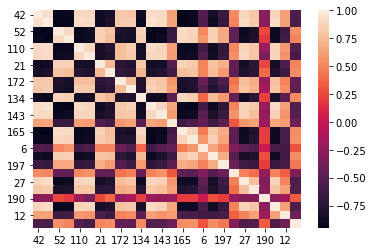

In [425]:
#pearson correlation
sns.heatmap(top_vec_df.corr())

In [427]:
top_vec_df[[text_col]+pos_columns]

,text_processed,42,16,52,106,110,2,21,161,172,...,15,6,3,197,0,27,43,190,11,12
3191,we have an opening for a writer on cnn s med...,0.710217,0.669058,-0.622519,-0.994394,0.668540,-0.035401,-0.709931,-0.668177,-0.032879,...,-0.519862,-1.477361,-1.151424,-0.863191,0.138128,0.165504,0.693151,-0.257020,0.576006,1.561087
5303,but as you know only the prime minister can ...,0.639718,0.656741,-0.655077,-0.110567,-0.086005,0.442825,-0.028805,-0.427544,0.457095,...,-0.135973,0.685871,0.379631,0.139422,-0.240187,0.789962,0.131369,-0.076082,0.377574,-0.533085
815,,0.283571,0.689301,-0.583735,-0.730295,0.514324,0.449765,-0.652670,-0.643393,0.297756,...,-0.258268,-1.699538,-0.675798,-1.062038,-0.505338,0.303198,0.629753,0.000085,0.699334,3.357064
2437,the smaller one jumped the gun and gave up hi...,0.664339,0.717891,-0.396562,-0.609385,0.644979,0.763456,-0.459659,-0.438638,0.388338,...,-0.302822,-0.664673,-0.070538,-0.792561,0.418173,0.317797,0.871216,-0.515777,0.744776,0.367403
2556,our great military has delivered justice for ...,0.581202,0.615805,-0.452405,-0.278976,0.672690,0.793206,0.038742,-0.412307,0.373852,...,-0.725638,-0.494390,-0.259171,-0.405936,0.116998,0.336068,0.775099,0.514542,0.429384,-0.225906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,ravens rookie wr miles boykin hauls in t...,0.046553,0.358695,-1.173967,-0.832400,1.124122,0.898037,-0.629095,-0.877584,0.464280,...,-1.165680,-1.144606,-1.990984,-1.343549,0.605311,1.052545,1.033747,-0.308452,1.296333,0.567193
4062,none,-1.480064,-1.510080,1.476410,1.446248,-1.450905,-1.432026,1.383335,1.267507,-1.298317,...,1.419522,0.837436,1.352203,1.071258,-0.799738,-1.433911,-1.281242,0.396187,-1.425799,-0.963122
1294,the most important role of the attorney gener...,0.653247,0.669862,-0.311306,-0.709207,0.897882,0.488947,-0.783321,-0.199043,0.865842,...,-0.474814,-1.396321,-0.386799,-0.411406,0.416025,0.676361,0.803386,0.133241,0.155828,0.410078
5689,so many familiar faces new episodes of what...,0.926068,0.781851,-0.681673,-0.715039,0.789014,0.582011,-1.009493,-0.832617,0.403302,...,-0.942385,-0.862963,-0.841570,0.482109,-0.145450,0.218592,0.569830,-0.103251,0.994841,1.120570


In [428]:
vec_pos_train=pd.DataFrame(train_vecs_glove_mean, index=y_train.index)[top_word_vectors]
vec_pos_val=pd.DataFrame(validation_vecs_glove_mean, index=y_validate.index)[top_word_vectors]

In [429]:
g_clf2 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
g_clf2.fit(vec_pos_train, y_train)
print(g_clf2.score(vec_pos_val, y_validate))

0.783859649122807


In [430]:
from sklearn import metrics
# Predicting with a test dataset
best_predict4=g_clf2.predict(vec_pos_val)
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(best_predict4)))
print("Logistic Regression Precision:",metrics.precision_score(y_validate, pd.Series(best_predict4)))
print("Logistic Regression Recall:",metrics.recall_score(y_validate, pd.Series(best_predict4)))
print("Logistic Regression F1 Score:",metrics.f1_score(y_validate, pd.Series(best_predict4)))

Logistic Regression Accuracy: 0.783859649122807
Logistic Regression Precision: 0.8607142857142858
Logistic Regression Recall: 0.6769662921348315
Logistic Regression F1 Score: 0.7578616352201257


Let's re-analyze with user account information in combination with all of our GloVe vectors:

In [431]:
glove_train_df=pd.DataFrame(train_vecs_glove_mean, index=y_train.index)
glove_val_df=pd.DataFrame(validation_vecs_glove_mean, index=y_validate.index)
glove_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
5471,1.227766,0.191172,0.586744,-0.462038,0.773748,0.049560,-0.310585,-0.620369,-1.808476,-1.025469,...,0.685361,0.509556,0.678868,0.853838,-0.245261,-1.444765,0.611869,0.406398,0.532527,0.355778
1714,0.505690,-0.182742,0.387636,-0.043820,0.348904,-0.881157,0.492882,-0.077841,-0.770110,-0.759847,...,0.074511,-0.711466,0.854370,-0.181913,0.799674,-0.504647,0.242947,0.461030,0.875351,0.851717
871,1.001400,-0.250927,0.618941,-0.295395,1.348074,-0.101504,-0.315866,-0.143359,-0.823375,-0.587404,...,-0.105310,-0.614036,0.167613,0.027244,0.673593,-0.211343,0.097010,0.043479,-0.367769,0.205902
2559,1.772358,0.255169,0.391679,-0.715851,0.427035,-0.225971,-0.370710,-1.708463,-1.461975,-1.145469,...,2.331673,1.582925,1.877791,0.168182,2.835803,2.429107,-0.477175,-3.431360,2.125876,-0.400037
2983,1.580809,0.389056,0.244732,-0.830205,0.489944,-0.222000,-0.706332,-0.860730,0.170039,-0.447527,...,-0.029559,-0.025276,0.308696,0.727618,-0.240192,0.504948,0.188322,-0.083374,0.022894,0.918078


In [436]:
np.array(glove_train_df.loc[5471])

array([ 1.22776633e+00,  1.91171901e-01,  5.86743550e-01, -4.62037742e-01,
        7.73747695e-01,  4.95603711e-02, -3.10585177e-01, -6.20368771e-01,
       -1.80847553e+00, -1.02546913e+00, -6.45704085e-01,  7.09422487e-01,
        2.42940772e-01,  9.55322161e-02, -3.34330133e-01, -7.61793147e-01,
        5.53770589e-01,  8.94258726e-02, -6.09444342e-01, -4.09160430e-01,
        1.49509706e-01, -1.78739041e-01, -7.76978899e-01,  6.52172482e-01,
       -7.57008391e-01,  4.01446576e-02,  8.39130830e-01,  4.74519508e-01,
       -8.82560082e-01,  1.14921669e-01,  9.75621993e-01,  8.25112789e-01,
       -6.77580072e-01, -1.15896123e+00,  5.06412546e-01, -5.69229523e-02,
       -2.10773263e-01, -5.62832534e-01,  4.70423182e-01, -2.44924688e-01,
       -3.86023869e-02, -1.16827320e+00,  6.39237964e-01,  4.57812441e-01,
        1.00399030e+00,  2.22914190e-01, -7.42893981e-01,  3.06210313e-01,
       -7.11538392e-01, -7.65884393e-01, -4.83801604e-01, -7.74274886e-02,
       -3.92708621e-01,  

In [437]:
#For gensim, look at most similar words, given a word vector:
glove_twitter.similar_by_vector(np.array(glove_train_df.loc[5471]), topn=10, restrict_vocab=None)

[('nears', 0.4547192454338074),
 ('impeachment', 0.4441034197807312),
 ('trial', 0.41882747411727905),
 ('verdict', 0.40884047746658325),
 ('underway', 0.3974319100379944),
 ('begins', 0.39579543471336365),
 ('emerges', 0.39305853843688965),
 ('ongoing', 0.38099247217178345),
 ('hearings', 0.3772731125354767),
 ('arrives', 0.37668853998184204)]

In [438]:
X_train.loc[5471][text_col]

' as the senate impeachment trial gets underway  here is a brief procedural recap on what has happened and what is expected in the coming days '

In [439]:
glove_merged_train_df=pd.concat([scaled_features.loc[X_train.index], glove_train_df], axis=1)
glove_merged_val_df=pd.concat([scaled_features.loc[X_validate.index], glove_val_df], axis=1)

In [440]:
glove_merged_train_df.head()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,doy,year,hour,minute,second,...,190,191,192,193,194,195,196,197,198,199
5471,-0.473880,-0.120951,-0.602382,-0.281997,-1.321145,-1.170710,1.666888,0.513694,1.384440,-1.257373,...,0.685361,0.509556,0.678868,0.853838,-0.245261,-1.444765,0.611869,0.406398,0.532527,0.355778
1714,-0.026340,-0.020735,0.516972,-0.110725,-0.728095,-0.433805,1.666888,0.381506,0.187376,-0.134057,...,0.074511,-0.711466,0.854370,-0.181913,0.799674,-0.504647,0.242947,0.461030,0.875351,0.851717
871,4.311772,-0.166322,3.889120,-0.288597,-0.721977,0.510680,-0.599920,-0.015056,-1.351707,-0.639549,...,-0.105310,-0.614036,0.167613,0.027244,0.673593,-0.211343,0.097010,0.043479,-0.367769,0.205902
2559,1.304457,-0.017866,1.211477,-0.279709,2.079413,-0.579110,1.666888,-1.469119,0.301382,0.933094,...,2.331673,1.582925,1.877791,0.168182,2.835803,2.429107,-0.477175,-3.431360,2.125876,-0.400037
2983,-0.452457,0.147277,-0.369512,-0.284998,0.518658,0.666364,-0.599920,0.249319,1.498446,1.494752,...,-0.029559,-0.025276,0.308696,0.727618,-0.240192,0.504948,0.188322,-0.083374,0.022894,0.918078


In [441]:
list(glove_merged_train_df.columns)

['followers_count',
 'friends_count',
 'listed_count',
 'favourites_count',
 'statuses_count',
 'doy',
 'year',
 'hour',
 'minute',
 'second',
 'encoded_urls',
 'encoded_hashtag',
 'num_hashtags',
 'url_present',
 'hashtag_present',
 'category',
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,


In [442]:
g_clf3 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
g_clf3.fit(glove_merged_train_df, y_train)
print(g_clf3.score(glove_merged_val_df, y_validate))

0.8617543859649123


In [443]:
# Predicting with a test dataset
best_predict5=g_clf3.predict(glove_merged_val_df)
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(best_predict5)))
print("Logistic Regression Precision:",metrics.precision_score(y_validate, pd.Series(best_predict5)))
print("Logistic Regression Recall:",metrics.recall_score(y_validate, pd.Series(best_predict5)))
print("Logistic Regression F1 Score:",metrics.f1_score(y_validate, pd.Series(best_predict5)))

Logistic Regression Accuracy: 0.8617543859649123
Logistic Regression Precision: 0.8428761651131824
Logistic Regression Recall: 0.8890449438202247
Logistic Regression F1 Score: 0.8653451811346549


Let's graph the ROC/AUC curve:

In [444]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.936


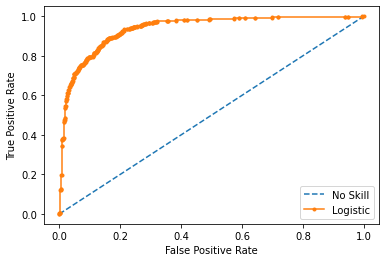

In [445]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_validate))]
# predict probabilities
lr_probs = g_clf3.predict_proba(glove_merged_val_df)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_validate, ns_probs)
lr_auc = roc_auc_score(y_validate, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_validate, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_validate, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Let's look at the most important features for the GloVe vectors/account info:

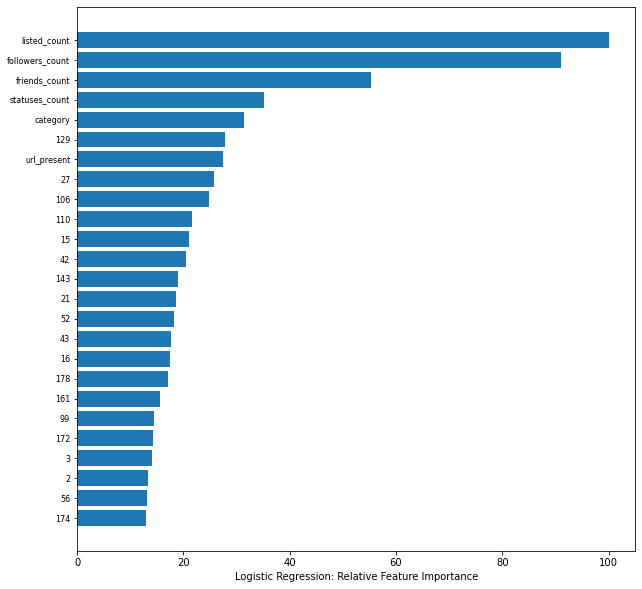

In [446]:
feature_importance = abs(g_clf3.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[::-1][:25][::-1]
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(glove_merged_val_df.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Logistic Regression: Relative Feature Importance')
plt.show()

<AxesSubplot:>

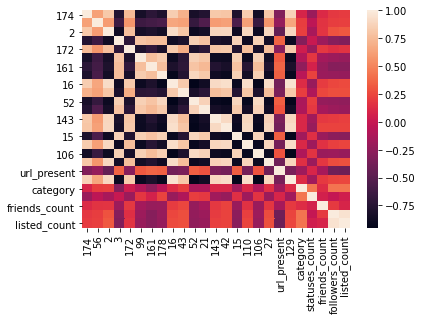

In [447]:
top_25=(glove_merged_val_df.columns)[sorted_idx]
#pearson correlation
sns.heatmap(glove_merged_val_df[top_25].corr())

In [448]:
top_25

Index([              174,                56,                 2,
                       3,               172,                99,
                     161,               178,                16,
                      43,                52,                21,
                     143,                42,                15,
                     110,               106,                27,
           'url_present',               129,        'category',
        'statuses_count',   'friends_count', 'followers_count',
          'listed_count'],
      dtype='object')

In [449]:
g_clf4 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
g_clf4.fit(glove_merged_train_df[top_25], y_train)
print(g_clf4.score(glove_merged_val_df[top_25], y_validate))

0.8666666666666667


Interestingly, the number of public lists and other account information are amongst the most important features. 

Field information (as defined by Twitter):
* followers_count: The number of followers this account currently has. Under certain conditions of duress, this field will temporarily indicate “0”. Example:
* friends_count: The number of users this account is following (AKA their “followings”). 
* listed_count: The number of public lists that this user is a member of. 
* favourites_count: The number of Tweets this user has liked in the account’s lifetime. British spelling used in the field name for historical reasons.
* statuses_count: The number of Tweets (including retweets) issued by the user.

In [450]:
glove_resid_train=residuals(clf=g_clf, X=glove_train_df, y=y_train)
glove_resid_val=residuals(clf=g_clf, X=glove_val_df, y=y_validate)

In [451]:
glove_account_rf=RandomForestRegressor(random_state=42).fit(account_train[['followers_count']], glove_resid_train)

In [452]:
glove_account_rf.score(account_val[['followers_count']], glove_resid_val)

0.2830660160460545

In [453]:
glove_results=add_resid_predictions(account_rf=glove_account_rf,account_val=account_val[['followers_count']], clf=g_clf, vector_X=glove_val_df, threshold=0.4)
glove_percent_prob=glove_results[0] #percent probability of being ratioed
glove_pred_new_prob=glove_results[1] #predictions (ratio/non-ratio)

In [454]:
#Predicting with a validation dataset
print("Combined Log Reg+ RF Regression Accuracy:",metrics.accuracy_score(y_validate, pd.Series(glove_pred_new_prob)))
print("Combined Log Reg+ RF Precision:",metrics.precision_score(y_validate, pd.Series(glove_pred_new_prob)))
print("Combined Log Reg+ RF Recall:",metrics.recall_score(y_validate, pd.Series(glove_pred_new_prob)))
print("Combined Log Reg+ RF F1 Score:",metrics.f1_score(y_validate, pd.Series(glove_pred_new_prob)))

Combined Log Reg+ RF Regression Accuracy: 0.8589473684210527
Combined Log Reg+ RF Precision: 0.8254777070063695
Combined Log Reg+ RF Recall: 0.9101123595505618
Combined Log Reg+ RF F1 Score: 0.8657314629258517


Let's use GridSearch to see if we can improve upon the model

In [457]:
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

In [458]:
# # Create regularization penalty space
# penalty = ['l1', 'l2']

# # Create regularization hyperparameter space
# C = np.logspace(0, 4, 10)

# solver=['liblinear','saga']

# # Create hyperparameter options
# hyperparameters = dict(C=C, penalty=penalty, solver=solver)


# # Create grid search using 5-fold cross validation
# clf_gs1 = GridSearchCV(LogisticRegression(max_iter=5000), hyperparameters, cv=5, verbose=0)

# best_clf2 = clf_gs1.fit(glove_merged_train_df, y_train)

In [459]:
# Create first pipeline for base without reducing features.

# # g_clf3 = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
# # g_clf3.fit(glove_merged_train_df, y_train)
# # print(g_clf3.score(glove_merged_val_df, y_validate))


# pipe = Pipeline([('classifier' , RandomForestClassifier())])

# # Create param grid.

# param_grid = [
#     {'classifier' : [LogisticRegression()],
#      'classifier__penalty' : ['l1', 'l2'],
#     'classifier__C' : np.logspace(-4, 4, 20),
#     'classifier__solver' : ['liblinear']},
#     {'classifier' : [RandomForestClassifier()],
#     'classifier__n_estimators' : list(range(10,101,10)),
#     'classifier__max_features' : list(range(6,32,5))}
# ]

# # Create grid search object

# clf_gs = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# # Fit on data

# best_clf = clf_gs.fit(glove_merged_train_df, y_train)

In [ ]:
# best_clf 

In [ ]:
# best_clf.score(glove_merged_val_df, y_validate) 

In [ ]:
# best_clf.best_params_

In [ ]:
# rf=RandomForestClassifier(n_estimators= 60, max_features=31).fit(glove_merged_train_df, y_train)

In [ ]:
# rf.score(glove_merged_val_df, y_validate)

In [ ]:
# feature_importance=rf.feature_importances_
# feature_importance = 100.0 * (feature_importance / feature_importance.max())
# sorted_idx = np.argsort(feature_importance)[::-1][:30][::-1]
# pos = np.arange(sorted_idx.shape[0]) + .5

# featfig = plt.figure(figsize=(20,10))
# featax = featfig.add_subplot(1, 1, 1)
# featax.barh(pos, feature_importance[sorted_idx], align='center')
# featax.set_yticks(pos)
# featax.set_yticklabels(np.array(glove_merged_val_df.columns)[sorted_idx], fontsize=8)
# featax.set_xlabel('Random Forest: Relative Feature Importance')
# plt.show()

In [ ]:
# sorted_idx = np.argsort(feature_importance)[::-1][:50][::-1]
# top_rf_features=np.array(glove_merged_val_df.columns)[sorted_idx]

In [ ]:
# rf2=RandomForestClassifier(n_estimators= 60, max_features=31).fit(glove_merged_train_df[top_rf_features], y_train)

In [ ]:
# rf2.score(glove_merged_val_df[top_rf_features], y_validate)

In [ ]:
# # Predicting with a test dataset
# best_predict_rf2=rf2.predict(glove_merged_val_df[top_rf_features])
# # Model Accuracy
# print("Random Forest Accuracy:",metrics.accuracy_score(y_validate, pd.Series(best_predict_rf2)))
# print("Random Forest Precision:",metrics.precision_score(y_validate, pd.Series(best_predict_rf2)))
# print("Random Forest Recall:",metrics.recall_score(y_validate, pd.Series(best_predict_rf2)))

In [ ]:
##Let's use eli5 to look at feature importance on the smaller features
!pip install eli5

In [ ]:
#eli5 feature importance
from eli5.sklearn import PermutationImportance
import eli5

In [ ]:
perm = PermutationImportance(rf2).fit(glove_merged_val_df[top_rf_features], y_validate)
exp_df = eli5.explain_weights_df(perm, feature_names = list(glove_merged_val_df[top_rf_features].columns))

In [ ]:
exp_df

In [ ]:
#pearson correlation
sns.heatmap(glove_merged_val_df[top_rf_features].corr())

Visualize tweets using T-SNE

In [ ]:
#t-SNE
from sklearn.manifold import TSNE  #Import the t-SNE algorithm

In [ ]:
X_embedded = TSNE(n_components=2).fit_transform(glove_merged_val_df[top_rf_features])
X_embedded.shape

In [ ]:
glove_merged_val_df[top_rf_features].head()

In [ ]:
#Plot the t-SNE output
fig, ax = plt.subplots()
ax.plot(X_embedded [:, 0], X_embedded [:, 1], 'o')
ax.set_title('Tweets')
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks
plt.show()

In [ ]:
#Fins similar words given a vector
glove_twitter.similar_by_vector(np.array(glove_val_df.loc[1370]), topn=5, restrict_vocab=None)

### Vader Sentiment Analysis

In [291]:
#!pip install vaderSentiment

In [475]:
text_col='cleaned_text'

In [476]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def vader_sentiment(texts=df[text_col]):
    vader_scores=[]
    sentences = texts
    analyzer = SentimentIntensityAnalyzer()
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        vader_scores.append(vs)
        #print("{:-<65} {}".format(sentence, str(vs)))
    
    return vader_scores

In [480]:
vader_scores_train=vader_sentiment(texts=df[text_col])

In [481]:
vader_df_train=pd.DataFrame({"sentiments":vader_scores_train, 'ratio_target':y_train}, index=df.index)

In [482]:
vader_df_train.head()

,sentiments,ratio_target
0,"{'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...",0.0
1,"{'neg': 0.144, 'neu': 0.856, 'pos': 0.0, 'comp...",NaN
2,"{'neg': 0.499, 'neu': 0.349, 'pos': 0.153, 'co...",0.0
3,"{'neg': 0.063, 'neu': 0.63, 'pos': 0.307, 'com...",0.0
4,"{'neg': 0.0, 'neu': 0.896, 'pos': 0.104, 'comp...",NaN


In [483]:
vader_df_train = pd.concat([vader_df_train.drop(['sentiments'], axis=1), vader_df_train['sentiments'].apply(pd.Series)], axis=1)

In [484]:
vader_df_train.head()

,ratio_target,neg,neu,pos,compound
0,0.0,0.000,0.727,0.273,0.7184
1,NaN,0.144,0.856,0.000,-0.5719
2,0.0,0.499,0.349,0.153,-0.9169
3,0.0,0.063,0.630,0.307,0.7003
4,NaN,0.000,0.896,0.104,0.2960


In [485]:
vader_df_train.ratio_target.unique()

array([ 0., nan,  1.])

/Users/michelewaters/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/michelewaters/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


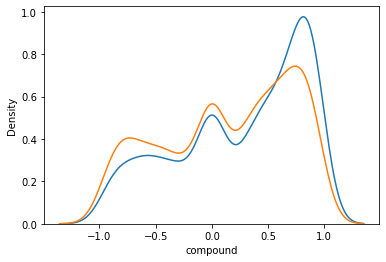

In [486]:
# plot sentiment distribution for positive and negative tweets

import seaborn as sns

for x in [0, 1]:
    subset = vader_df_train[vader_df_train['ratio_target']== x]
    #subset = vader_df.loc[train_idx][vader_df.loc[train_idx]['ratio_target']== x]
    # Draw the density plot
    if x == 0:
        label = "Non-ratioed tweet"
    else:
        label = "Ratioed tweet"
    sns.distplot(subset['compound'], hist = False, label = label)

/Users/michelewaters/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/michelewaters/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


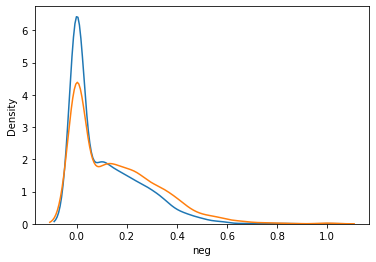

In [487]:
# plot sentiment distribution for positive and negative tweets

import seaborn as sns

for x in [0, 1]:
    subset = vader_df_train[vader_df_train['ratio_target']== x]
    #subset = vader_df.loc[train_idx][vader_df.loc[train_idx]['ratio_target']== x]
    # Draw the density plot
    if x == 0:
        label = "Non-ratioed tweet"
    else:
        label = "Ratioed tweet"
    sns.distplot(subset['neg'], hist = False, label = label)

/Users/michelewaters/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/michelewaters/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


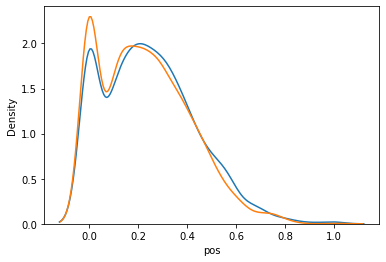

In [488]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = vader_df_train[vader_df_train['ratio_target']== x]
    #subset = vader_df.loc[train_idx][vader_df.loc[train_idx]['ratio_target']== x]
    # Draw the density plot
    if x == 0:
        label = "Non-ratioed tweet"
    else:
        label = "Ratioed tweet"
    sns.distplot(subset['pos'], hist = False, label = label)

/Users/michelewaters/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/michelewaters/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


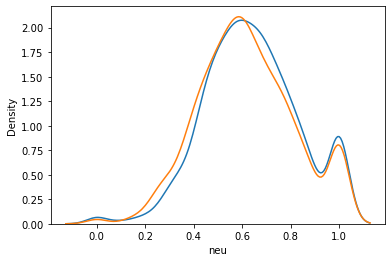

In [489]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = vader_df_train[vader_df_train['ratio_target']== x]
    #subset = vader_df.loc[train_idx][vader_df.loc[train_idx]['ratio_target']== x]
    # Draw the density plot
    if x == 0:
        label = "Non-ratioed tweet"
    else:
        label = "Ratioed tweet"
    sns.distplot(subset['neu'], hist = False, label = label)

* Might need to re-think strategy on time-dependency (i.e. make training data only early/2019, and validate on more recent data/2020). However, due to the low frequency of ratios in dataset, just used random/undersampling strategy, with equal distribution of ratios in training and validation data 